In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

from solar_energy_forecast.preprocess import get_data

In [5]:
df = get_data(verbose=True)


## PV data:
                  count     mean       std  min     50%     max
relative_power  20571.0  0.23569  0.252558  0.0  0.1297  1.0169

## Solar data:
                      count     mean     std     min      50%      max
DHI                 43824.0    62.52   93.97    0.00     0.00   476.00
DNI                 43824.0   192.04  308.79    0.00     0.00  1029.00
GHI                 43824.0   167.16  252.45    0.00     0.00  1022.00
Clearsky DHI        43824.0    48.26   59.40    0.00     0.00   416.00
Clearsky DNI        43824.0   327.65  367.59    0.00     0.00  1029.00
Clearsky GHI        43824.0   227.65  300.72    0.00     0.00  1022.00
Cloud Type          43824.0     3.42    3.05    0.00     4.00    10.00
Dew Point           43824.0     6.72    8.95  -19.00     7.00    24.00
Solar Zenith Angle  43824.0    89.68   35.05   18.95    89.57   161.15
Fill Flag           43824.0     1.93   11.52    0.00     0.00   100.00
Surface Albedo      43824.0     0.23    0.26    0.11     0.13 

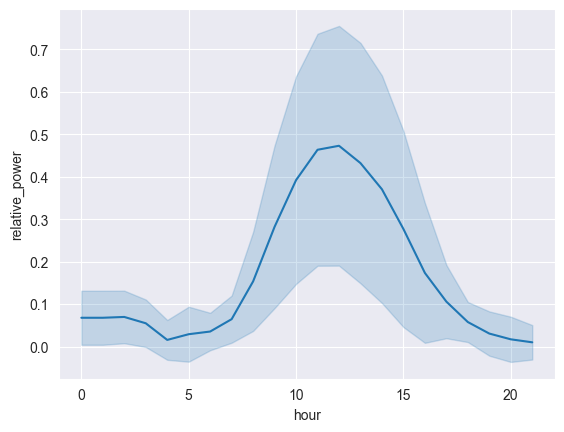

In [44]:
df["hour"] = df.index.hour
sns.lineplot(df, y="relative_power", x="hour", errorbar="sd")
plt.savefig('output/relative_power_by_hour.png')

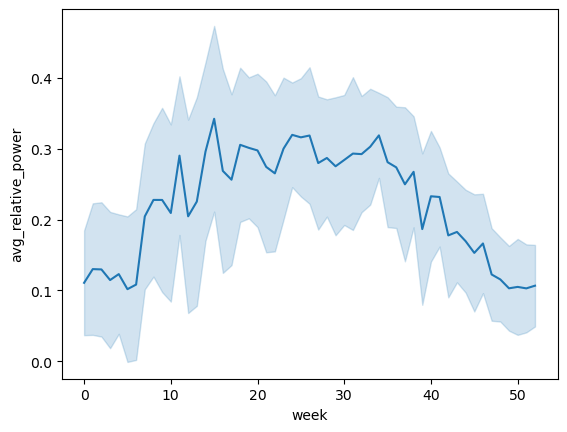

In [7]:
df["day_of_year"] = df.index.day_of_year
df["date"] = df.index.date
df["week"] = df.index.day_of_year // 7
sns.lineplot(
    df.groupby("date").agg(avg_relative_power=("relative_power", "mean"), week=("week", "first")),
    y="avg_relative_power", x="week", errorbar="sd", estimator='mean')
plt.savefig('output/avg_relative_power_by_week.png')

## Data Modification

## Training

In [ ]:
X = df.select_dtypes(include='number').drop(columns="relative_power")
y = df["relative_power"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
clf = Ridge(alpha=1.0)
clf.fit(X_train, y_train)

Ridge()

In [17]:
len(clf.coef_)

37

In [19]:
df.shape

(20571, 43)

In [25]:
df.select_dtypes(include='object')

,moonrise,moonset,sunrise,sunset,date
date_time,,,,,
2014-01-01 07:00:00,06:58 AM,05:05 PM,07:12 AM,04:22 PM,2014-01-01
2014-01-01 08:00:00,06:58 AM,05:05 PM,07:12 AM,04:22 PM,2014-01-01
2014-01-01 09:00:00,06:58 AM,05:05 PM,07:12 AM,04:22 PM,2014-01-01
2014-01-01 10:00:00,06:58 AM,05:05 PM,07:12 AM,04:22 PM,2014-01-01
2014-01-01 11:00:00,06:58 AM,05:05 PM,07:12 AM,04:22 PM,2014-01-01
...,...,...,...,...,...
2018-03-05 13:00:00,09:49 PM,08:24 AM,06:12 AM,05:38 PM,2018-03-05
2018-03-05 14:00:00,09:49 PM,08:24 AM,06:12 AM,05:38 PM,2018-03-05
2018-03-05 15:00:00,09:49 PM,08:24 AM,06:12 AM,05:38 PM,2018-03-05


## Evaluation

In [8]:
y_pred = clf.predict(X_test)
y_pred = np.where(y_pred > 0, y_pred, 0)

In [9]:
rmse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
normlized_rmse = np.mean(
    mean_squared_error(y_test, y_pred, multioutput='raw_values') /
    np.max(np.stack([y_pred, y_test.to_numpy()]), axis=0)
)
{"RMSE": rmse, "MAE": mae, "nRMSE": float(normlized_rmse)}

{'RMSE': 0.018460188057809863,
 'MAE': 0.10102556232005339,
 'nRMSE': 1.2932359165550544}

## Analysis

In [30]:
df_params = X_train.mean().rename("mean_value").to_frame()
df_params["coef"] = clf.coef_
df_params["mean_weight"] = df_params["coef"] * df_params["mean_value"]
df_params.sort_values("mean_weight", ascending=False, inplace=True)
df_params

,mean_value,coef,mean_weight
tempC,12.409820,0.040879,0.507299
windspeedKmph,15.960379,0.012420,0.198235
week,25.173554,0.007387,0.185961
FeelsLikeC,10.740459,0.010531,0.113103
Relative Humidity,81.493597,0.001126,0.091777
HeatIndexC,12.819336,0.002971,0.038083
sunHour,10.395704,0.003446,0.035819
Clearsky DHI,66.853731,0.000529,0.035393
DNI,259.853488,0.000130,0.033705
DHI,90.495564,0.000248,0.022475


<Axes: >

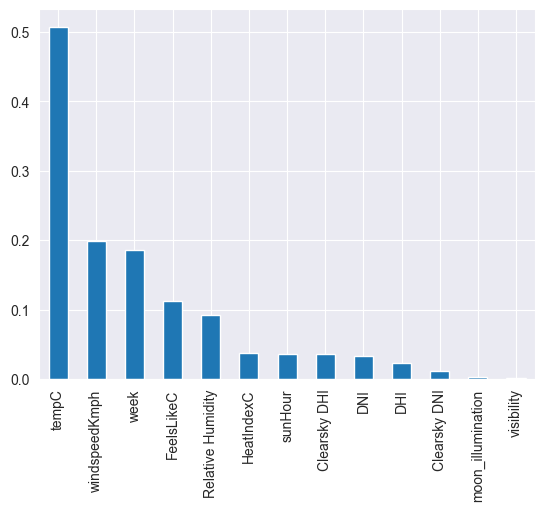

In [41]:
df_params[df_params["mean_weight"] > 0]["mean_weight"].plot(kind="bar")